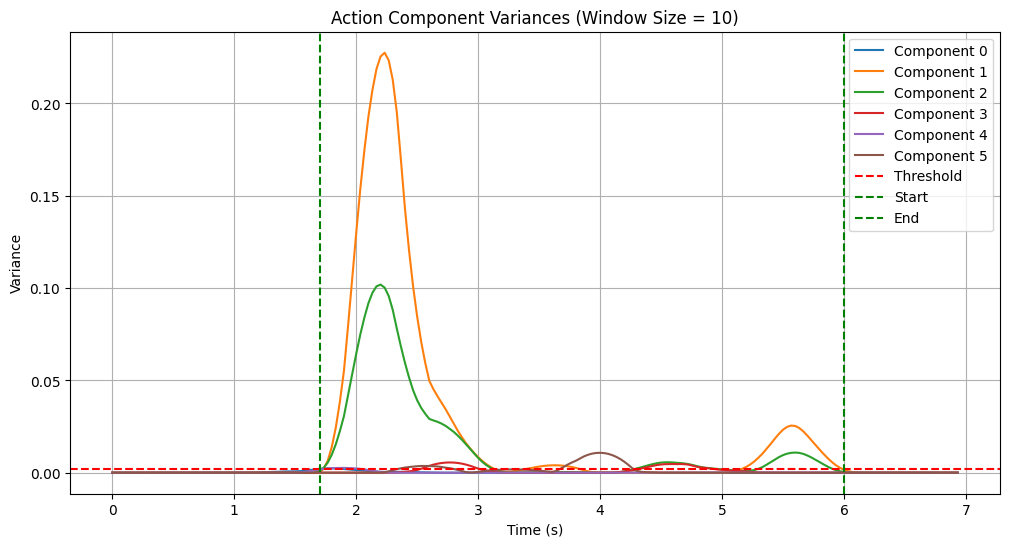

In [3]:
import parquet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the parquet file
df = pd.read_parquet('datasets/hada1/data/chunk-000/episode_000001.parquet')
df.head()

threshold = 0.002
start_time = 51/30
end_time = 180/30

def calculate_window_variance(actions, center_idx, window_size):
    # Get window boundaries
    start_idx = max(0, center_idx - window_size)
    end_idx = min(len(actions), center_idx + window_size + 1)
    
    # Extract actions in the window
    window_actions = actions[start_idx:end_idx]
    
    # Convert to 2D array where each row is a flattened action
    flattened_actions = []
    for action in window_actions:
        if isinstance(action, np.ndarray) and action.size > 0:
            flattened_actions.append(action)
        else:
            # Convert string representation to numpy array
            action_array = np.array(eval(action))
            flattened_actions.append(action_array)
    
    # Stack into 2D array (rows are time steps, columns are action components)
    action_matrix = np.stack(flattened_actions)
    
    # Calculate variance across time (axis=0) for each component
    component_variances = np.var(action_matrix, axis=0)
    return component_variances

# Calculate variance for each position
window_size = 10
all_variances = []
for i in range(len(df)):
    variances = calculate_window_variance(df['action'], i, window_size)
    all_variances.append(variances)

# Convert to numpy array for easier plotting
all_variances = np.array(all_variances)

# Plot variances over time for each component
plt.figure(figsize=(12, 6))
for component_idx in range(all_variances.shape[1]):
    plt.plot(df['timestamp'], all_variances[:, component_idx], 
             label=f'Component {component_idx}')

plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axvline(x=start_time, color='g', linestyle='--', label='Start')
plt.axvline(x=end_time, color='g', linestyle='--', label='End')


plt.xlabel('Time (s)')
plt.ylabel('Variance')
plt.title(f'Action Component Variances (Window Size = {window_size})')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
import glob
from pathlib import Path
import pandas as pd
import cv2

# Find all parquet files in chunk-001
parquet_files = glob.glob("datasets/hada1/data_processed/chunk-000/*.parquet")

print("Episode lengths:")
print("-" * 55)
print(f"{'Episode':20} {'Parquet Rows':>15} {'Video Frames':>15}")
print("-" * 55)

for parquet_path in sorted(parquet_files):
    # Read parquet file
    df = pd.read_parquet(parquet_path)
    
    # Get episode number from filename
    episode_name = Path(parquet_path).stem
    
    # Find corresponding video file
    video_pattern = f"datasets/hada1_processed/videos/chunk-000/**/{episode_name}.mp4"
    video_files = glob.glob(video_pattern, recursive=True)
    
    if video_files:
        video_path = video_files[0]
        # Get number of frames
        cap = cv2.VideoCapture(video_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
    else:
        frame_count = "Not found"
    
    if (len(df) != frame_count):
        print(f"{episode_name:20} {len(df):>15} {frame_count:>15}")


Episode lengths:
-------------------------------------------------------
Episode                 Parquet Rows    Video Frames
-------------------------------------------------------
